<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg">
    
## [mlcourse.ai](https://mlcourse.ai) - Open Machine Learning Course

Authors: [Maria Sumarokova](https://www.linkedin.com/in/mariya-sumarokova-230b4054/), and [Yury Kashnitsky](https://www.linkedin.com/in/festline/). Translated and edited by Gleb Filatov, Aleksey Kiselev, [Anastasia Manokhina](https://www.linkedin.com/in/anastasiamanokhina/), [Egor Polusmak](https://www.linkedin.com/in/egor-polusmak/), and [Yuanyuan Pao](https://www.linkedin.com/in/yuanyuanpao/). All content is distributed under the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.

# <center> Assignment #3 (demo)
## <center>  Decision trees with a toy task and the UCI Adult dataset 

Same assignment as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees) + [solution](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees-solution). Fill in the answers in the [web-form](https://docs.google.com/forms/d/1wfWYYoqXTkZNOPy1wpewACXaj2MZjBdLOL58htGWYBA/edit).

Let's start by loading all necessary libraries:

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize': (9, 6)})

### Part 1. Toy dataset "Will They? Won't They?"

Your goal is to figure out how decision trees work by walking through a toy problem. While a single decision tree does not yield outstanding results, other performant algorithms like gradient boosting and random forests are based on the same idea. That is why knowing how decision trees work might be useful.

We'll go through a toy example of binary classification - Person A is deciding whether they will go on a second date with Person B. It will depend on their looks, eloquence, alcohol consumption (only for example), and how much money was spent on the first date.

In [2]:
# Create dataframe with dummy variables
def create_df(dict_, feature_list):
    out = pd.DataFrame(dict_)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis = 1)
    out.drop(feature_list, axis = 1, inplace = True)
    return out

# Some feature values are present in train and absent in test and vice-versa.
def intersect_features(train, test):
    common_feat = list( set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [3]:
features = ['Looks', 'Alcoholic_beverage','Eloquence','Money_spent']

#### Training data

In [4]:
from sklearn.preprocessing import LabelEncoder

df_train = {
    'Looks': ['handsome', 'handsome', 'handsome', 'repulsive',
              'repulsive', 'repulsive', 'handsome'],
    'Alcoholic_beverage': ['yes', 'yes', 'no', 'no',
                           'yes', 'yes', 'yes'],
    'Eloquence': ['high', 'low', 'average', 'average',
                  'low', 'high', 'average'],
    'Money_spent': ['lots', 'little', 'lots', 'little',
                    'lots', 'lots', 'lots']
}
df_train['Will_go'] = LabelEncoder().fit_transform(['+', '-', '+', '-',
                                                    '-', '+', '+'])

df_train = create_df(df_train, features)
df_train

,Will_go,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Eloquence_low,Money_spent_little,Money_spent_lots
0,0,1,0,0,1,0,1,0,0,1
1,1,1,0,0,1,0,0,1,1,0
2,0,1,0,1,0,1,0,0,0,1
3,1,0,1,1,0,1,0,0,1,0
4,1,0,1,0,1,0,0,1,0,1
5,0,0,1,0,1,0,1,0,0,1
6,0,1,0,0,1,1,0,0,0,1


#### Test data

In [5]:
df_test = {
    'Looks': ['handsome', 'handsome', 'repulsive'],
    'Alcoholic_beverage': ['no', 'yes', 'yes'],
    'Eloquence': ['average', 'high', 'average'],
    'Money_spent': ['lots', 'little', 'lots']
}

df_test = create_df(df_test, features)
df_test

,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Money_spent_little,Money_spent_lots
0,1,0,1,0,1,0,0,1
1,1,0,0,1,0,1,1,0
2,0,1,0,1,1,0,0,1


In [6]:
# Some feature values are present in train and absent in test and vice-versa.
y = df_train['Will_go']
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Money_spent_little,Looks_handsome,Eloquence_high,Alcoholic_beverage_yes,Eloquence_average,Money_spent_lots,Looks_repulsive,Alcoholic_beverage_no
0,0,1,1,1,0,1,0,0
1,1,1,0,1,0,0,0,0
2,0,1,0,0,1,1,0,1
3,1,0,0,0,1,0,1,1
4,0,0,0,1,0,1,1,0
5,0,0,1,1,0,1,1,0
6,0,1,0,1,1,1,0,0


In [7]:
df_test

,Money_spent_little,Looks_handsome,Eloquence_high,Alcoholic_beverage_yes,Eloquence_average,Money_spent_lots,Looks_repulsive,Alcoholic_beverage_no
0,0,1,0,0,1,1,0,1
1,1,1,1,1,0,0,0,0
2,0,0,0,1,1,1,1,0


#### Draw a decision tree (by hand or in any graphics editor) for this dataset. Optionally you can also implement tree construction and draw it here.

1\. What is the entropy $S_0$ of the initial system? By system states, we mean values of the binary feature "Will_go" - 0 or 1 - two states in total.

In [8]:
probs = y.value_counts(normalize=True)
initial_info = -sum(np.multiply(probs, np.log2(probs)))
initial_info

0.9852281360342515

2\. Let's split the data by the feature "Looks_handsome". What is the entropy $S_1$ of the left group - the one with "Looks_handsome". What is the entropy $S_2$ in the opposite group? What is the information gain (IG) if we consider such a split?

In [9]:
# Split by 'Looks_handsome' >= 0.5:
#      True /       \ False
#    0,0,0,1        0,1,1
left_probs = pd.Series([0,0,0,1]).value_counts(normalize=True)
entropy_1 = -sum(np.multiply(left_probs, np.log2(left_probs)))

right_probs = pd.Series([0,1,1]).value_counts(normalize=True)
entropy_2 = -sum(np.multiply(right_probs, np.log2(right_probs)))

information_gained = initial_info - sum([4*entropy_1, 3*entropy_2])/len(df_train)
entropy_1, entropy_2, information_gained

(0.8112781244591328, 0.9182958340544896, 0.12808527889139443)

#### Train a decision tree using sklearn on the training data. You may choose any depth for the tree.

In [10]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=4)
tree.fit(df_train, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

#### Additional: display the resulting tree using graphviz. You can use pydot or [web-service](https://www.coolutils.com/ru/online/DOT-to-PNG) dot2png.

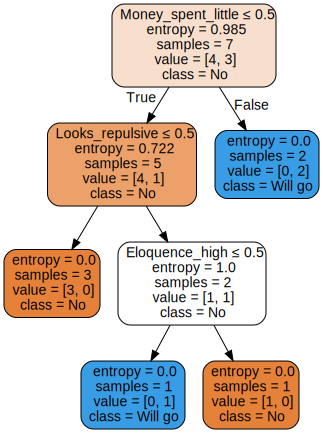

In [11]:
# from sklearn.tree import plot_tree
# plot_tree(tree, filled=True, class_names=['No', 'Will go'])    # version >= 0.21

from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(tree, out_file=None,
                           feature_names=list(df_train.columns),
                           class_names=['No', 'Will go'],
                           filled=True, rounded=True,
                           special_characters=True)
graphviz.Source(dot_data)

### Part 2. Functions for calculating entropy and information gain.

Consider the following warm-up example: we have 9 blue balls and 11 yellow balls. Let a ball have label **1** if it is blue, **0** otherwise.

In [12]:
balls = [1 for i in range(9)] + [0 for i in range(11)]

<img src = 'https://habrastorage.org/webt/mu/vl/mt/muvlmtd2njeqf18trbldenpqvnm.png'>

Next split the balls into two groups:

<img src='https://habrastorage.org/webt/bd/aq/5w/bdaq5wi3c4feezaexponvin8wmo.png'>

In [13]:
# two groups
balls_left  = [1 for i in range(8)] + [0 for i in range(5)] # 8 blue and 5 yellow
balls_right = [1 for i in range(1)] + [0 for i in range(6)] # 1 blue and 6 yellow

#### Implement a function to calculate the Shannon Entropy

In [14]:
def entropy(labels):
    """ Return Shannon entropy of list of labels: [0, 3, 1,...]. """
    probs = pd.Series(labels).value_counts(normalize=True)
    return -sum(np.multiply(probs, np.log2(probs)))

In [15]:
# Tests
print(entropy(balls)) # 9 blue и 11 yellow
print(entropy(balls_left)) # 8 blue и 5 yellow
print(entropy(balls_right)) # 1 blue и 6 yellow
print(entropy([1,2,3,4,5,6])) # entropy of a fair 6-sided die

0.9927744539878083
0.9612366047228759
0.5916727785823275
2.584962500721156


3\. What is the entropy of the state given by the list **balls_left**?

0.96

4\. What is the entropy of a fair dice? (where we look at a dice as a system with 6 equally probable states)?

2.58

In [16]:
def information_gain(root, left, right):
    """ root - initial data, left and right - two splits of initial data. """
    splitted = sum([len(left)*entropy(left), len(right)*entropy(right)])/len(root)
    return entropy(root) - splitted

5\. What is the information gain from splitting the initial dataset into **balls_left** and **balls_right** ?

In [17]:
information_gain(balls, balls_left, balls_right)

0.16088518841412436

### Part 3. The "Adult" dataset

[Dataset](http://archive.ics.uci.edu/ml/machine-learning-databases/adult) UCI Adult (no need to download it, we have a copy in the course repository): classify people using demographical data - whether they earn more than \$50,000 per year or not.

Feature descriptions:
- **Age** – continuous feature
- **Workclass** –  continuous feature
- **fnlwgt** – final weight of object, continuous feature
- **Education** –  categorical feature
- **Education_Num** – number of years of education, continuous feature
- **Marital_Status** –  categorical feature
- **Occupation** –  categorical feature
- **Relationship** – categorical feature
- **Race** – categorical feature
- **Sex** – categorical feature
- **Capital_Gain** – continuous feature
- **Capital_Loss** – continuous feature
- **Hours_per_week** – continuous feature
- **Country** – categorical feature

**Target** – earnings level, categorical (binary) feature.

In [18]:
data_train = pd.read_csv('../input/adult_train.csv').rename(columns={'Martial_Status': 'Marital_Status'})
print(data_train.shape)
data_train.tail()

(32561, 15)


,Age,Workclass,fnlwgt,Education,Education_Num,Marital_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [19]:
data_test = pd.read_csv('../input/adult_test.csv').rename(columns={'Martial_Status': 'Marital_Status'})
print(data_test.shape)
data_test.tail()

(16282, 15)


,Age,Workclass,fnlwgt,Education,Education_Num,Marital_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.
16281,35,Self-emp-inc,182148.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K.


In [20]:
# necessary to remove rows with incorrect labels in test dataset
data_test.dropna(subset=['Target'], inplace=True)

# encode target variable as integer
data_train.loc[data_train['Target']==' <=50K', 'Target'] = 0
data_train.loc[data_train['Target']==' >50K', 'Target'] = 1

data_test.loc[data_test['Target']==' <=50K.', 'Target'] = 0
data_test.loc[data_test['Target']==' >50K.', 'Target'] = 1
data_test.tail(3)

,Age,Workclass,fnlwgt,Education,Education_Num,Marital_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,0
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,0
16281,35,Self-emp-inc,182148.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,1


#### Primary data analysis

In [21]:
data_test.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281,NaN,NaN,NaN,189436,105715,13492,116736,177831,238384,1.4904e+06
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281,NaN,NaN,NaN,10.0729,2.56755,1,9,10,12,16
Marital_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
data_train['Target'].value_counts()

0    24720
1     7841
Name: Target, dtype: int64

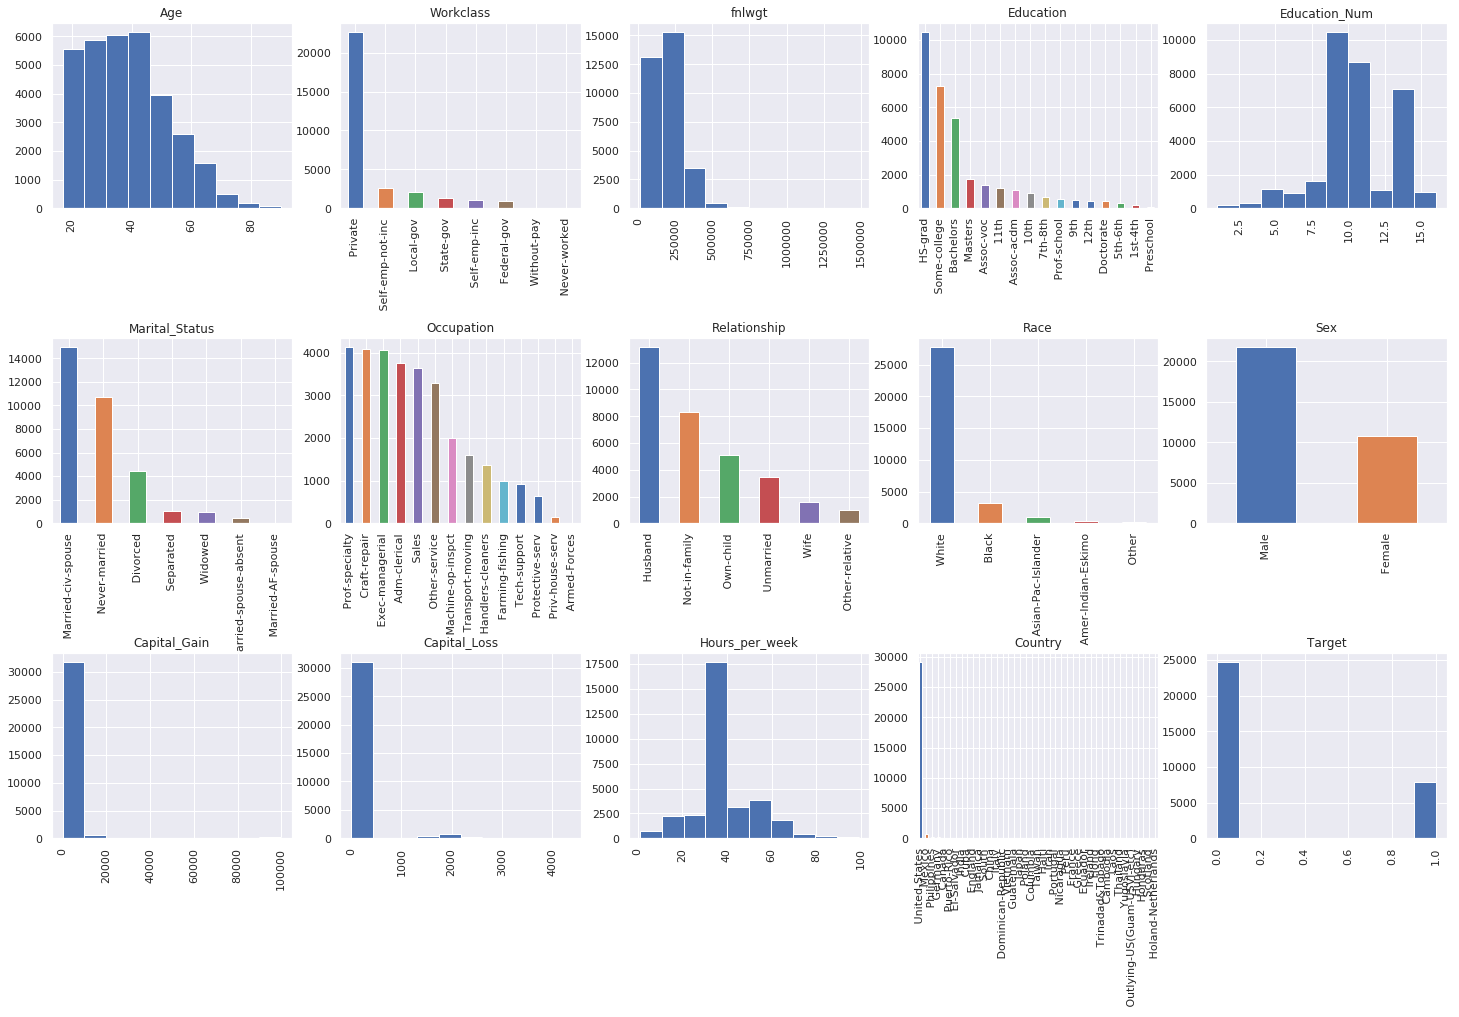

In [23]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = np.ceil(data_train.shape[1] / cols)
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == np.object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

#### Checking data types

In [24]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Marital_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target             int64
dtype: object

In [25]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Marital_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target              int64
dtype: object

As we see, in the test data, age is treated as type **object**. We need to fix this.

In [26]:
data_test['Age'] = data_test['Age'].astype(int)

Also we'll cast all **float** features to **int** type to keep types consistent between our train and test data.

In [27]:
data_test['fnlwgt'] = data_test['fnlwgt'].astype(int)
data_test['Education_Num'] = data_test['Education_Num'].astype(int)
data_test['Capital_Gain'] = data_test['Capital_Gain'].astype(int)
data_test['Capital_Loss'] = data_test['Capital_Loss'].astype(int)
data_test['Hours_per_week'] = data_test['Hours_per_week'].astype(int)

#### Fill in missing data for continuous features with their median values, for categorical features with their mode.

In [28]:
categorical_columns = [c for c in data_train.columns 
                       if data_train[c].dtype.name == 'object']
numerical_columns = [c for c in data_train.columns 
                     if data_train[c].dtype.name != 'object']

print('categorical_columns:', categorical_columns)
print('numerical_columns:', numerical_columns)

categorical_columns: ['Workclass', 'Education', 'Marital_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
numerical_columns: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week', 'Target']


In [29]:
# we see some missing values
data_train.isna().sum()

Age                  0
Workclass         1836
fnlwgt               0
Education            0
Education_Num        0
Marital_Status       0
Occupation        1843
Relationship         0
Race                 0
Sex                  0
Capital_Gain         0
Capital_Loss         0
Hours_per_week       0
Country            583
Target               0
dtype: int64

In [30]:
# fill missing data
for c in categorical_columns:
    data_train[c].fillna(data_train[c].mode()[0], inplace=True)
    data_test[c].fillna(data_train[c].mode()[0], inplace=True)
    
for c in numerical_columns:
    data_train[c].fillna(data_train[c].median(), inplace=True)
    data_test[c].fillna(data_train[c].median(), inplace=True)

In [31]:
# no more missing values
print(data_train.isna().sum().sum())
data_test.isna().sum()

0


Age               0
Workclass         0
fnlwgt            0
Education         0
Education_Num     0
Marital_Status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_Gain      0
Capital_Loss      0
Hours_per_week    0
Country           0
Target            0
dtype: int64

We'll dummy code some categorical features: **Workclass**, **Education**, **Martial_Status**, **Occupation**, **Relationship**, **Race**, **Sex**, **Country**. It can be done via pandas method **get_dummies**:

In [32]:
data_train = pd.concat([data_train[numerical_columns],
    pd.get_dummies(data_train[categorical_columns])], axis='columns')

data_test = pd.concat([data_test[numerical_columns],
    pd.get_dummies(data_test[categorical_columns])], axis='columns')
data_test.tail(3)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,Workclass_ Self-emp-inc,Workclass_ Self-emp-not-inc,Workclass_ State-gov,Workclass_ Without-pay,Education_ 10th,Education_ 11th,Education_ 12th,Education_ 1st-4th,Education_ 5th-6th,Education_ 7th-8th,Education_ 9th,Education_ Assoc-acdm,Education_ Assoc-voc,Education_ Bachelors,Education_ Doctorate,Education_ HS-grad,Education_ Masters,Education_ Preschool,Education_ Prof-school,Education_ Some-college,Marital_Status_ Divorced,Marital_Status_ Married-AF-spouse,Marital_Status_ Married-civ-spouse,Marital_Status_ Married-spouse-absent,Marital_Status_ Never-married,Marital_Status_ Separated,Marital_Status_ Widowed,Occupation_ Adm-clerical,Occupation_ Armed-Forces,...,Country_ Cambodia,Country_ Canada,Country_ China,Country_ Columbia,Country_ Cuba,Country_ Dominican-Republic,Country_ Ecuador,Country_ El-Salvador,Country_ England,Country_ France,Country_ Germany,Country_ Greece,Country_ Guatemala,Country_ Haiti,Country_ Honduras,Country_ Hong,Country_ Hungary,Country_ India,Country_ Iran,Country_ Ireland,Country_ Italy,Country_ Jamaica,Country_ Japan,Country_ Laos,Country_ Mexico,Country_ Nicaragua,Country_ Outlying-US(Guam-USVI-etc),Country_ Peru,Country_ Philippines,Country_ Poland,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
16279,38,374983,13,0,0,50,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
16280,44,83891,13,5455,0,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
16281,35,182148,13,0,0,60,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [33]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [34]:
data_train.shape, data_test.shape

((32561, 106), (16281, 105))

#### There is no Holland in the test data. Create new zero-valued feature.

In [35]:
data_test['Country_ Holand-Netherlands'] = 0

In [36]:
set(data_train.columns) - set(data_test.columns)

set()

In [37]:
data_train.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,Workclass_ Self-emp-inc,Workclass_ Self-emp-not-inc,Workclass_ State-gov,Workclass_ Without-pay,Education_ 10th,Education_ 11th,Education_ 12th,Education_ 1st-4th,Education_ 5th-6th,Education_ 7th-8th,Education_ 9th,Education_ Assoc-acdm,Education_ Assoc-voc,Education_ Bachelors,Education_ Doctorate,Education_ HS-grad,Education_ Masters,Education_ Preschool,Education_ Prof-school,Education_ Some-college,Marital_Status_ Divorced,Marital_Status_ Married-AF-spouse,Marital_Status_ Married-civ-spouse,Marital_Status_ Married-spouse-absent,Marital_Status_ Never-married,Marital_Status_ Separated,Marital_Status_ Widowed,Occupation_ Adm-clerical,Occupation_ Armed-Forces,...,Country_ Canada,Country_ China,Country_ Columbia,Country_ Cuba,Country_ Dominican-Republic,Country_ Ecuador,Country_ El-Salvador,Country_ England,Country_ France,Country_ Germany,Country_ Greece,Country_ Guatemala,Country_ Haiti,Country_ Holand-Netherlands,Country_ Honduras,Country_ Hong,Country_ Hungary,Country_ India,Country_ Iran,Country_ Ireland,Country_ Italy,Country_ Jamaica,Country_ Japan,Country_ Laos,Country_ Mexico,Country_ Nicaragua,Country_ Outlying-US(Guam-USVI-etc),Country_ Peru,Country_ Philippines,Country_ Poland,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [38]:
data_test.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,Workclass_ Self-emp-inc,Workclass_ Self-emp-not-inc,Workclass_ State-gov,Workclass_ Without-pay,Education_ 10th,Education_ 11th,Education_ 12th,Education_ 1st-4th,Education_ 5th-6th,Education_ 7th-8th,Education_ 9th,Education_ Assoc-acdm,Education_ Assoc-voc,Education_ Bachelors,Education_ Doctorate,Education_ HS-grad,Education_ Masters,Education_ Preschool,Education_ Prof-school,Education_ Some-college,Marital_Status_ Divorced,Marital_Status_ Married-AF-spouse,Marital_Status_ Married-civ-spouse,Marital_Status_ Married-spouse-absent,Marital_Status_ Never-married,Marital_Status_ Separated,Marital_Status_ Widowed,Occupation_ Adm-clerical,Occupation_ Armed-Forces,...,Country_ Canada,Country_ China,Country_ Columbia,Country_ Cuba,Country_ Dominican-Republic,Country_ Ecuador,Country_ El-Salvador,Country_ England,Country_ France,Country_ Germany,Country_ Greece,Country_ Guatemala,Country_ Haiti,Country_ Honduras,Country_ Hong,Country_ Hungary,Country_ India,Country_ Iran,Country_ Ireland,Country_ Italy,Country_ Jamaica,Country_ Japan,Country_ Laos,Country_ Mexico,Country_ Nicaragua,Country_ Outlying-US(Guam-USVI-etc),Country_ Peru,Country_ Philippines,Country_ Poland,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
1,25,226802,7,0,0,40,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,38,89814,9,0,0,50,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [39]:
X_train = data_train.drop(['Target'], axis='columns')
y_train = data_train['Target']

X_test = data_test.drop(['Target'], axis='columns')
y_test = data_test['Target']

### 3.1 Decision tree without tuning

Train a decision tree **(DecisionTreeClassifier)** with a maximum depth of 3, and evaluate the accuracy metric on the test data. Use parameter **random_state = 17** for results reproducibility.

In [40]:
from sklearn.metrics import accuracy_score

tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)
accuracy_score(y_test, tree.predict(X_test))

0.8447884036607088

6\. What is the test set accuracy of a decision tree with maximum tree depth of 3 and **random_state = 17**?

0.84

### 3.2 Decision tree with tuning of parameters

Train a decision tree **(DecisionTreeClassifier, random_state = 17).** Find the optimal maximum depth using 5-fold cross-validation **(GridSearchCV)**.

In [41]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth': range(2,11)}

search = GridSearchCV(DecisionTreeClassifier(random_state=17),
                      param_grid=params, cv=5, n_jobs=-1)
search.fit(X_train, y_train)
search.best_score_, search.best_params_

(0.8565768864592611, {'max_depth': 9})

Train a decision tree with best maximum depth and compute the accuracy of the test set.

In [42]:
best_tree = search.best_estimator_
accuracy_score(y_test, best_tree.predict(X_test))

0.847798046803022

7\. What is the test set accuracy of a decision tree with maximum depth of 9 and **random_state = 17**?

0.848

### 3.3 (Optional) Random forest without tuning

Let's take a sneak peek of upcoming lectures and try to use a random forest for our task. For now, you can imagine a random forest as a bunch of decision trees, trained on slightly different subsets of the training data.

Train a random forest **(RandomForestClassifier)**. Set the number of trees to 100 and use **random_state = 17**.

In [43]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50, random_state=17)
rf.fit(X_train, y_train)
accuracy_score(y_test, rf.predict(X_test))

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


0.8583625084454272

### 3.4 (Optional) Random forest with tuning of parameters

Train a random forest **(RandomForestClassifier)**. Tune the maximum depth and maximum number of features for each tree using **GridSearchCV**. 

In [44]:
%%time
params = {'max_depth': range(9, 21),
          'max_features': range(5, 105, 30)}

search = GridSearchCV(RandomForestClassifier(n_estimators=50, random_state=17),
                      param_grid=params, cv=5, n_jobs=-1)
search.fit(X_train, y_train)
print(search.best_score_, search.best_params_)

0.8640705138048586 {'max_depth': 16, 'max_features': 35}
CPU times: user 9.55 s, sys: 706 ms, total: 10.3 s
Wall time: 9min 10s


Make predictions for the test data and assess accuracy.

In [45]:
best_rf = search.best_estimator_
accuracy_score(y_test, best_rf.predict(X_test))

0.8657330630796634